In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import fbeta_score

import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.rcParams['axes.unicode_minus'] = False # 顯示負號

In [2]:
tfidf_train_data = pd.read_csv('../Data/TrainingData/tfidf_train.csv')
tfidf_val_data = pd.read_csv('../Data/ValidateData/tfidf_val.csv')
word2vec_train_data = pd.read_csv('../Data/TrainingData/word2vec_train.csv')
word2vec_val_data = pd.read_csv('../Data/ValidateData/word2vec_val.csv')
bert_train_data = pd.read_csv('../Data/TrainingData/bert_train.csv')
bert_val_data = pd.read_csv('../Data/ValidateData/bert_val.csv')

In [3]:
def train_knn_model(df, model_path, scaler_path):
    data = df.copy()
    y = data.pop('source')

    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data.values)
    joblib.dump(scaler, scaler_path)

    # decomposition
    from sklearn.decomposition import PCA

    pca = PCA(n_components=50)
    X_pca = pca.fit_transform(X_scaled)

    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

    # GridSearchCV
    param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}
    knn = KNeighborsClassifier()
    grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='f1')
    grid_search.fit(X_train, y_train)
    
    best_knn = grid_search.best_estimator_
    joblib.dump(best_knn, model_path)

    print("Best parameters found: ", grid_search.best_params_)

    y_pred_train = best_knn.predict(X_train)
    y_pred_test = best_knn.predict(X_test)

    cm_train = confusion_matrix(y_train, y_pred_train)
    cm_test = confusion_matrix(y_test, y_pred_test)

    # confusion matrix
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    sns.heatmap(cm_train, annot=True, fmt='d', ax=ax[0], cmap='Blues')
    ax[0].set_title('Train Confusion Matrix')
    ax[0].set_xlabel('Predicted')
    ax[0].set_ylabel('Actual')

    sns.heatmap(cm_test, annot=True, fmt='d', ax=ax[1], cmap='Blues')
    ax[1].set_title('Test Confusion Matrix')
    ax[1].set_xlabel('Predicted')
    ax[1].set_ylabel('Actual')

    plt.show()

    return best_knn, scaler, pca

In [4]:
def evaluate_on_new_data(model, scaler, pca, new_data):
    data = new_data.copy()
    y_new = data.pop('source')
    X_new_scaled = scaler.transform(data.values)
    X_new_pca = pca.transform(X_new_scaled)
    
    y_pred_new = model.predict(X_new_pca)

    new_f2 = fbeta_score(y_new, y_pred_new, beta=2)
    cm_new = confusion_matrix(y_new, y_pred_new)

    print(f'New Data F2 Score: {new_f2:.4f}')

    # confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_new, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix on New Data')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

Best parameters found:  {'n_neighbors': 9}


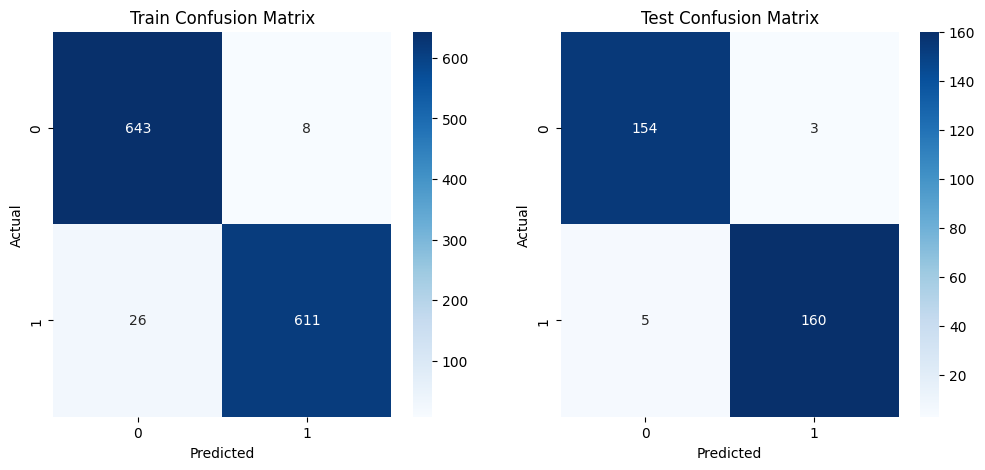

New Data F2 Score: 0.9519


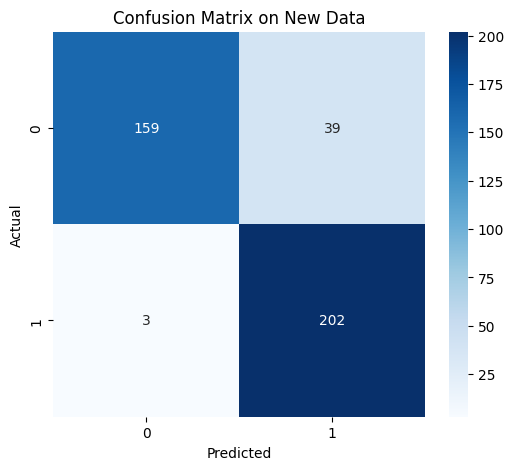

In [5]:
model, scaler, pca = train_knn_model(tfidf_train_data, '../Data/Model/tfidf_knn_model.pkl', '../Data/Model/tfidf_scaler.pkl')
evaluate_on_new_data(model, scaler, pca, tfidf_val_data)

Best parameters found:  {'n_neighbors': 11}


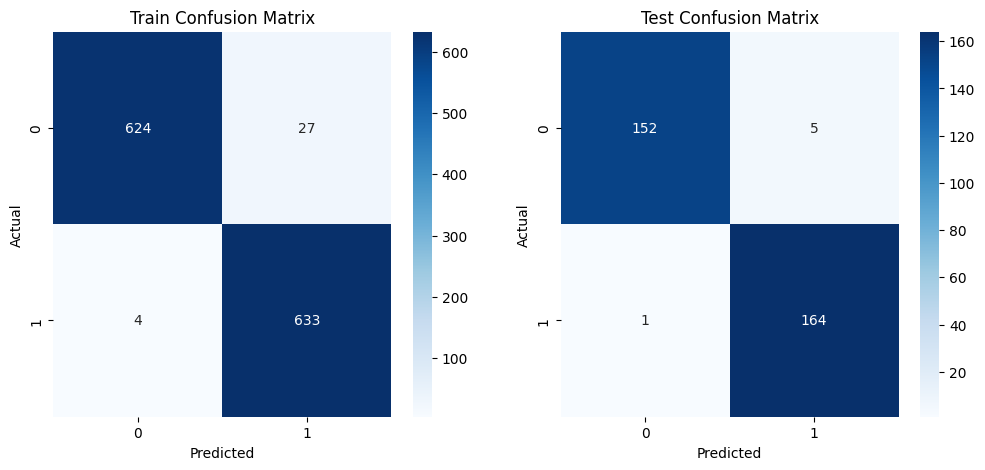

New Data F2 Score: 0.9748


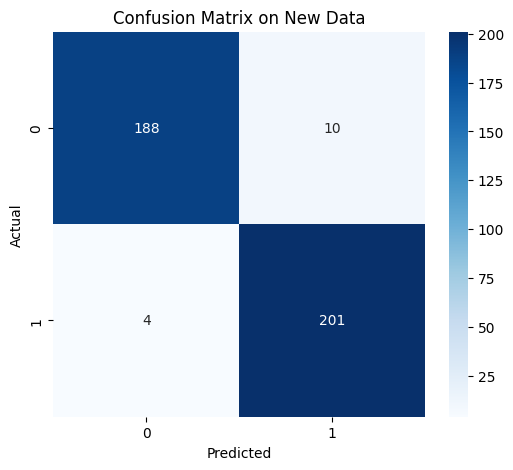

In [6]:
model, scaler, pca = train_knn_model(word2vec_train_data, '../Data/Model/word2vec_knn_model.pkl', '../Data/Model/word2vec_scaler.pkl')
evaluate_on_new_data(model, scaler, pca, word2vec_val_data)

Best parameters found:  {'n_neighbors': 7}


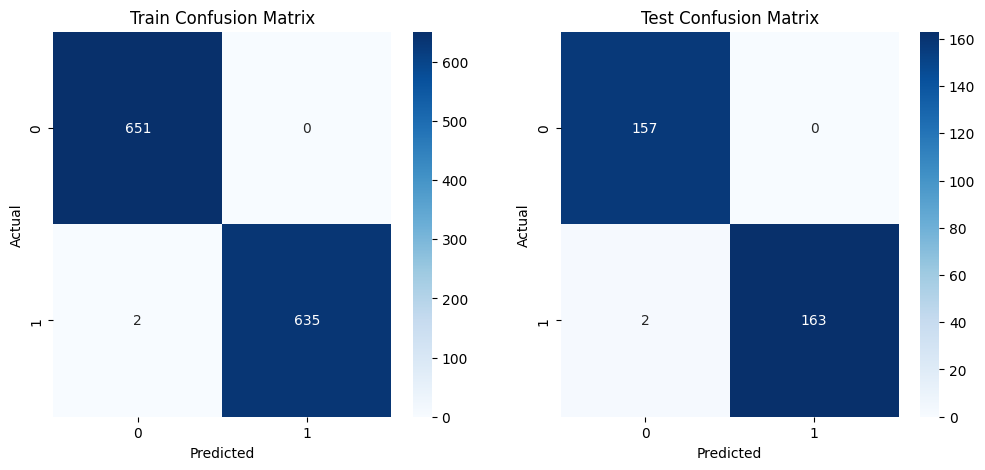

New Data F2 Score: 0.9922


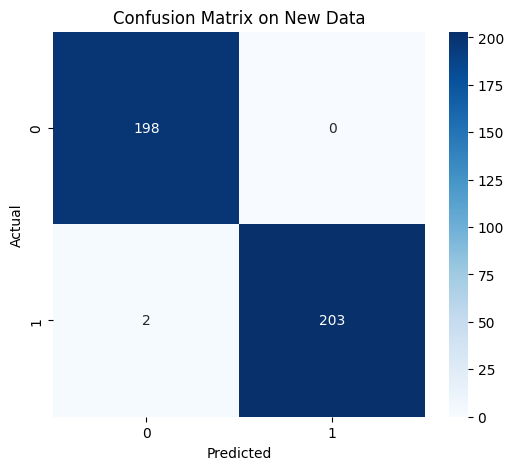

In [7]:
model, scaler, pca = train_knn_model(bert_train_data, '../Data/Model/bert_knn_model.pkl', '../Data/Model/bert_scaler.pkl')
evaluate_on_new_data(model, scaler, pca, bert_val_data)